### 음성 신호 처리 기초
1. 음성 신호 시각화 - Librosa, torchaudio, soundfile
2. 음성 신호 푸리에 변환 - NumPy
3. Mel-Spectrogram 변환 
4. MFCC 변환 과정 살펴보기 

### 1. 음성 신호 시각화
- librosa와 torchaudio, soundfile 이 샘플링하는 방식이 상이하므로, 시각화 결과도 다르게 나옴

In [2]:
!pip install librosa torchaudio matplotlib soundfile

In [3]:
import librosa
import librosa.display
import torchaudio
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np

In [4]:
audio_path = "/home/jieun/SR_basic/sample/9211s4_432.wav"

In [5]:
# Librosa
y_lib, sr_lib = librosa.load(audio_path, sr=None)  # 원본 SR 유지
print(f"[librosa] shape: {y_lib.shape}, sr: {sr_lib}")

# torchaudio
y_tor, sr_tor = torchaudio.load(audio_path)
print(f"[torchaudio] shape: {y_tor.shape}, sr: {sr_tor}")

# soundfile
data, sr = sf.read(audio_path)  # data: ndarray, sr: 샘플링 레이트
print(f"[soundfile] shape: {data.shape}, sr: {sr}")
if len(data.shape) > 1:
    data_mono = data[:, 0]
else:
    data_mono = data
    

[librosa] shape: (23600,), sr: 16000
[torchaudio] shape: torch.Size([1, 23600]), sr: 16000
[soundfile] shape: (23600,), sr: 16000


/home/jieun/.venv/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/jieun/.venv/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information

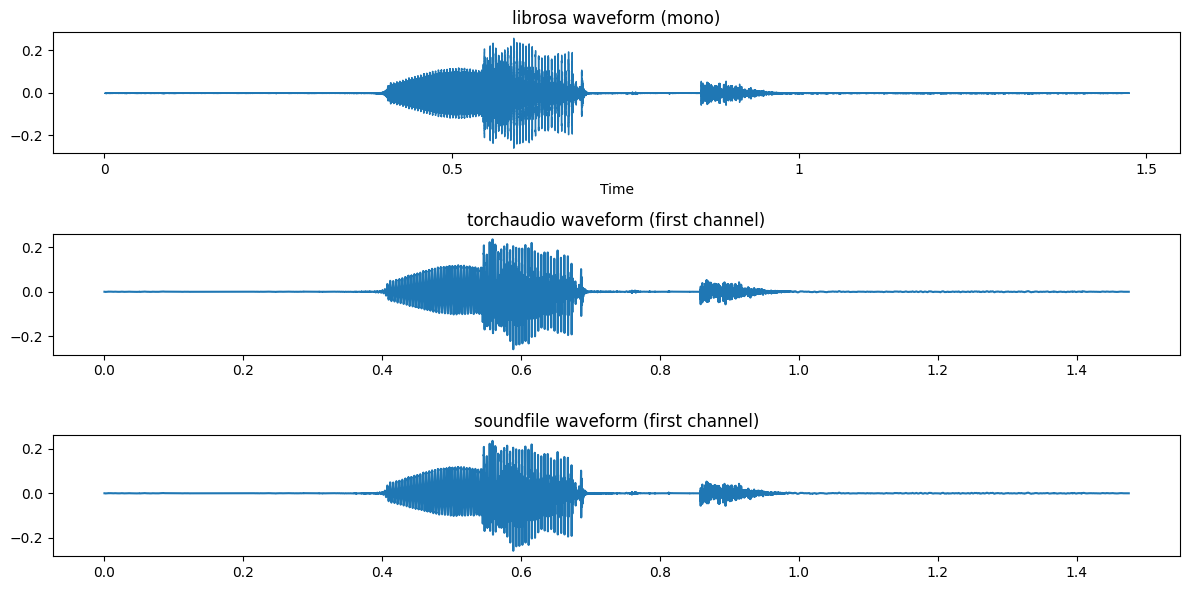

In [6]:
# librosa, torchaudio, soundfile sampling visualization

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
librosa.display.waveshow(y_lib, sr=sr_lib)
plt.title("librosa waveform (mono)")

plt.subplot(3, 1, 2)
plt.plot(np.linspace(0, len(y_tor[0]) / sr_tor, num=len(y_tor[0])), y_tor[0].numpy())
plt.title("torchaudio waveform (first channel)")

plt.subplot(3, 1, 3)
plt.plot(np.linspace(0, len(data_mono)/sr, num=len(data_mono)), data_mono)
plt.title("soundfile waveform (first channel)")


plt.tight_layout()
plt.show()

#### librosa != torchaudio, soundfile
- librosa.load()는 기본적으로 stereo -> mono로 변환, 좌우 채널 평균을 내서 waveform이 달라질 수 있음.
- librosa는 numpy float32로 [-1,1]로 정규화. 반면, torchaudio 및 soundfile은 원본 샘플 값 그대로


In [7]:
print("librosa first 10 samples:", y_lib[:10])
print()
print("torchaudio first 10 samples:", y_tor[0][:10].numpy())
print()
print("soundfile first 10 samples:", data_mono[:10])

librosa first 10 samples: [ 0.0000000e+00 -6.1035156e-05 -6.1035156e-05  0.0000000e+00
 -1.2207031e-04 -1.2207031e-04 -3.0517578e-05 -6.1035156e-05
 -6.1035156e-05  6.1035156e-05]

torchaudio first 10 samples: [ 0.0000000e+00 -6.1035156e-05 -6.1035156e-05  0.0000000e+00
 -1.2207031e-04 -1.2207031e-04 -3.0517578e-05 -6.1035156e-05
 -6.1035156e-05  6.1035156e-05]

soundfile first 10 samples: [ 0.00000000e+00 -6.10351562e-05 -6.10351562e-05  0.00000000e+00
 -1.22070312e-04 -1.22070312e-04 -3.05175781e-05 -6.10351562e-05
 -6.10351562e-05  6.10351562e-05]


### 2. 음성 신호 푸리에 변환

- NumPy, Librosa, torchaudio 등의 라이브러리로 가능하지만, numpy로 확인

In [8]:
y, sr = librosa.load(audio_path, sr=None) 

# FFT
fft = np.fft.fft(y) # y신호를 시간 도메인 신호를 주파수 도메인으로 변환, 결과는 복소수 배열, 각 요소는 신호의 특정 주파수 성분의 진폭과 위상을 나타냄
magnitude = np.abs(fft)
freq = np.linspace(0, sr, len(magnitude))


- y=signal in time-domain, sr=sampling_rate
- 푸리에 변환 (샘플링된 신호에 대해 -> 이산 푸리에 변환)
    - 신호를 시간 도메인 신호를 주파수 도메인으로 변환
    - 이 신호 안에 k 주파수가 얼마나(진폭) 들어있는지 측정하는 것
    - 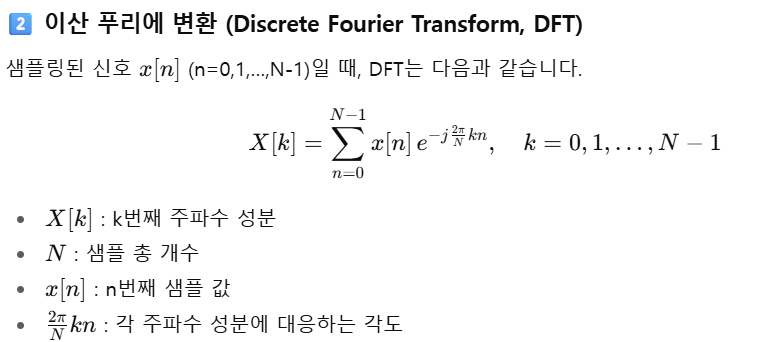
    - 전체 샘플 x[n]을 조각조각을 나누어서, **곱해서 합하면** 해당 k(해당 주파수 대역) - X[k]가 크고, 신호에 k가 적으면 X[k]가 적다 
    - X[k] - k(특정 주파수대)에 대한 진폭(magnitude)와 위상정보(파동이 시간축에서 얼마나 밀려 있는지)
    - 결과는 복소수 배열 = 크기 + 위상정보로 나타남
    - 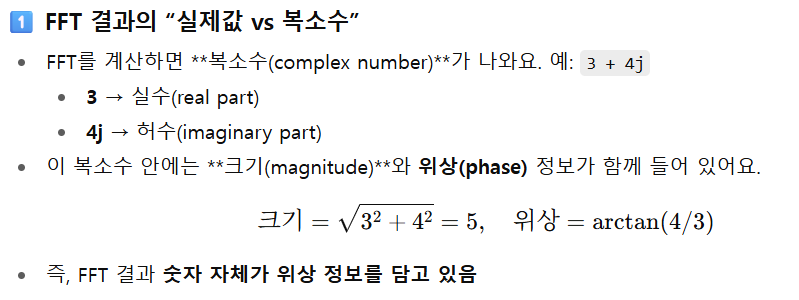
    - 하지만 그래프 상에서는 .abs()를 통해 복소수에서 '크기' 부분만 뽑은 것이라, 위상정보는 사라진 것처럼 보이는 것이다.

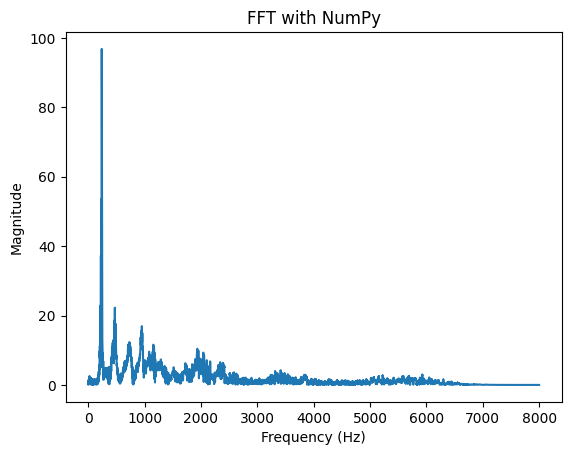

In [9]:

# 절반만 시각화 (대칭 구조이므로)
plt.plot(freq[:len(freq)//2], magnitude[:len(magnitude)//2])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT with NumPy")
plt.show()

### 3. Mel-Spectrogram
- Mel-scale로 

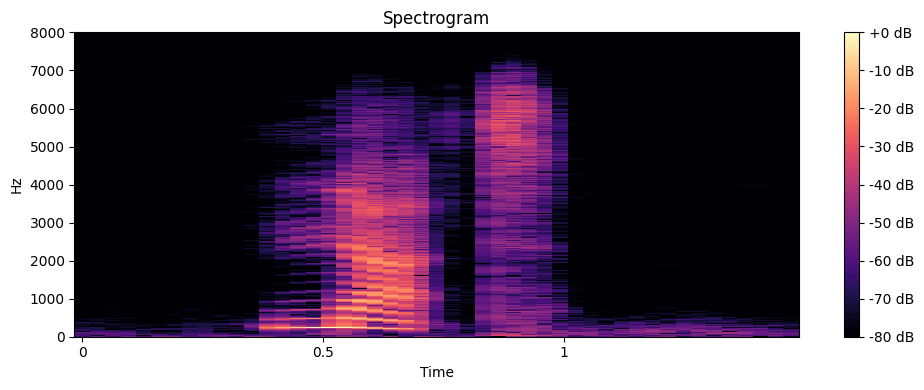

In [10]:
# 일반 Spectrogram
# STFT(Short-Time Fourier Transform) 계산
D = librosa.stft(y)            # 복소수 형태의 STFT: 짧은 구간마다 FFT를 적용하여 시간-주파수 생성
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)  # 복소수 -> magnitude -> dB 단위로 변환 (로그 스케일을 사용하므로 스펙트럼의 세부적 차이를 더 잘 시각화)

# 스펙트로그램 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

In [11]:
# Mel-Spectrogram 시각화

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=512, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)


#### Mel-Spectrogram
- 스펙트로그램이란 소리나 파동을 시각화하여 파악하기 위한 도구로, 파형(waveform)(시간-진폭)과 스펙트럼(spectrum)(주파수-진폭)의 특징이 조합되어 있다. 이들을 조합한 스펙트로그램은 x축에 시간(Time), y축에 주파수(Frequency), z축에 진폭(Amplitude)
- 일반 스펙트로그램은 주파수를 선형으로 나누지만, mel-spectrogram은 사람 귀의 특성(높은 주파수일수록 변화를 느끼지 못함)을 반영한 비선형 방식으로 
- 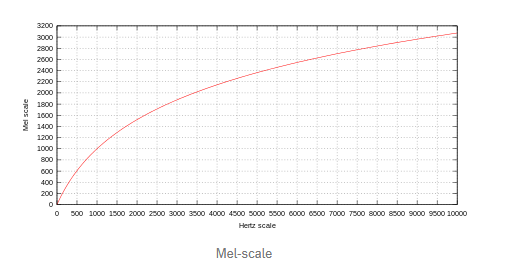
- y에 대해 멜 스펙트로그램을 계산
- n_mels=128: 멜 밴드의 개수, 128개로 주파수 영역을 나눔
- fmax=8000: 멜 스펙트로그램에서 사용할 최대 주파수(Hz)
- n_fft은 FFT를 계산할 때 사용되는 윈도우 크기를 지정한다. 이 크기가 크면 주파수 해상도는 높아지고 시간 해상도는 낮아진다
- hop_length는 인접한 프레임 사이의 샘플 수를 지정한다.
- librosa.power_to_db는 멜 스펙트로그램의 파워 값을 **데시벨 단위로 변환**하여 동적 범위를 압축하고 **로그 스케일**로 표현한다. (단순 멜 스펙트로그램 말고 로그 멜 스펙트로그램 구하기 위해)
- 훈련 시, Mel-spectrogram / Log Mel-spectrogram 그냥 통으로 넣는다.
- 참고 https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53 
- https://dohyeon-ai.tistory.com/2

#### n_mel에 대해
- 멜 스펙트로그램은 주파수 축을 멜 스케일로 나눈 격자라고 생각하면 됩니다.
- n_mels는 이 격자의 세로(주파수) 해상도를 결정
- n_mels=128 → 128개의 멜 밴드로 나눔
- n_mels=64 → 64개의 밴드로 나눔 (주파수 해상도 낮음) - 전체적인 형태만 확인 가능, 세부 패턴은 잘 안 보임
- n_mels=256 → 256개의 밴드로 나눔 (주파수 해상도 높음) - 더 선명하고 세밀한 주파수 패턴 확인 가능, 값이 커질수록 멜 밴드 수가 많아지고, 계산량 증가

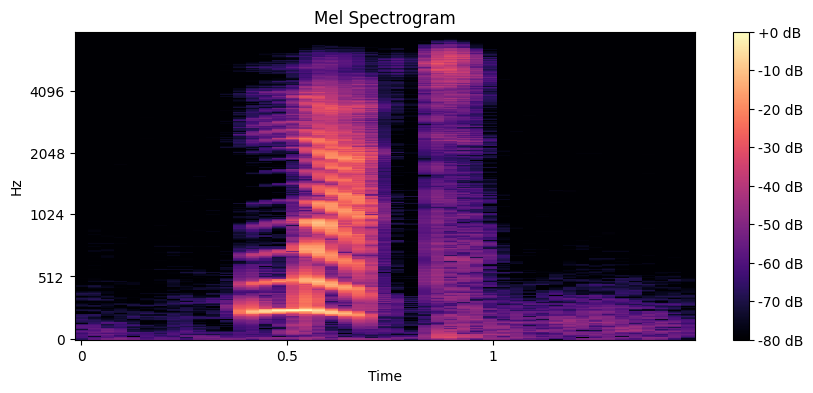

In [12]:

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

In [13]:
S_low = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_low_dB = librosa.power_to_db(S_low, ref=np.max)

S_high = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=1024, fmax=8000)
S_high_dB = librosa.power_to_db(S_high, ref=np.max)

/home/jieun/.venv/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


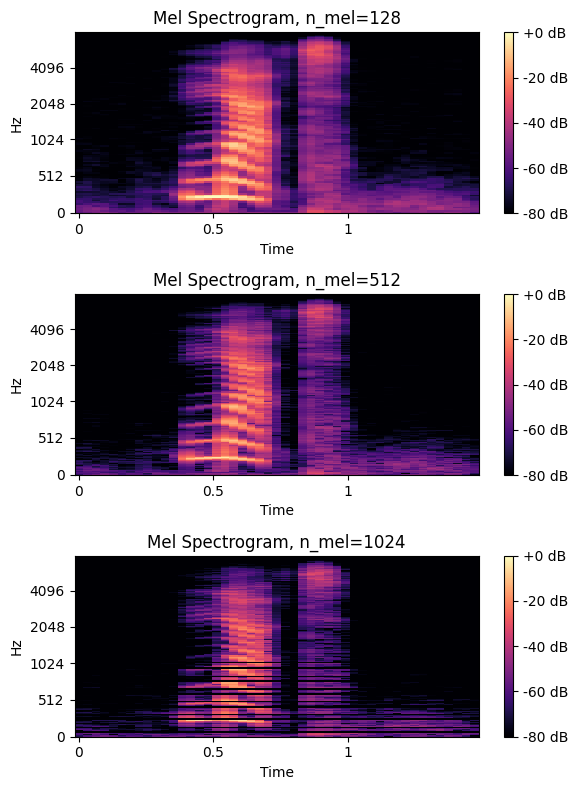

In [14]:

plt.figure(figsize=(6, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(S_low_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram, n_mel=128')

plt.subplot(3, 1, 2)
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel',  fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram, n_mel=512')

plt.subplot(3, 1, 3)
librosa.display.specshow(S_high_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram, n_mel=1024')


plt.tight_layout()
plt.show()

### 4. MFCC 변환 과정 시각화

/home/jieun/.venv/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/jieun/.venv/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information

16000


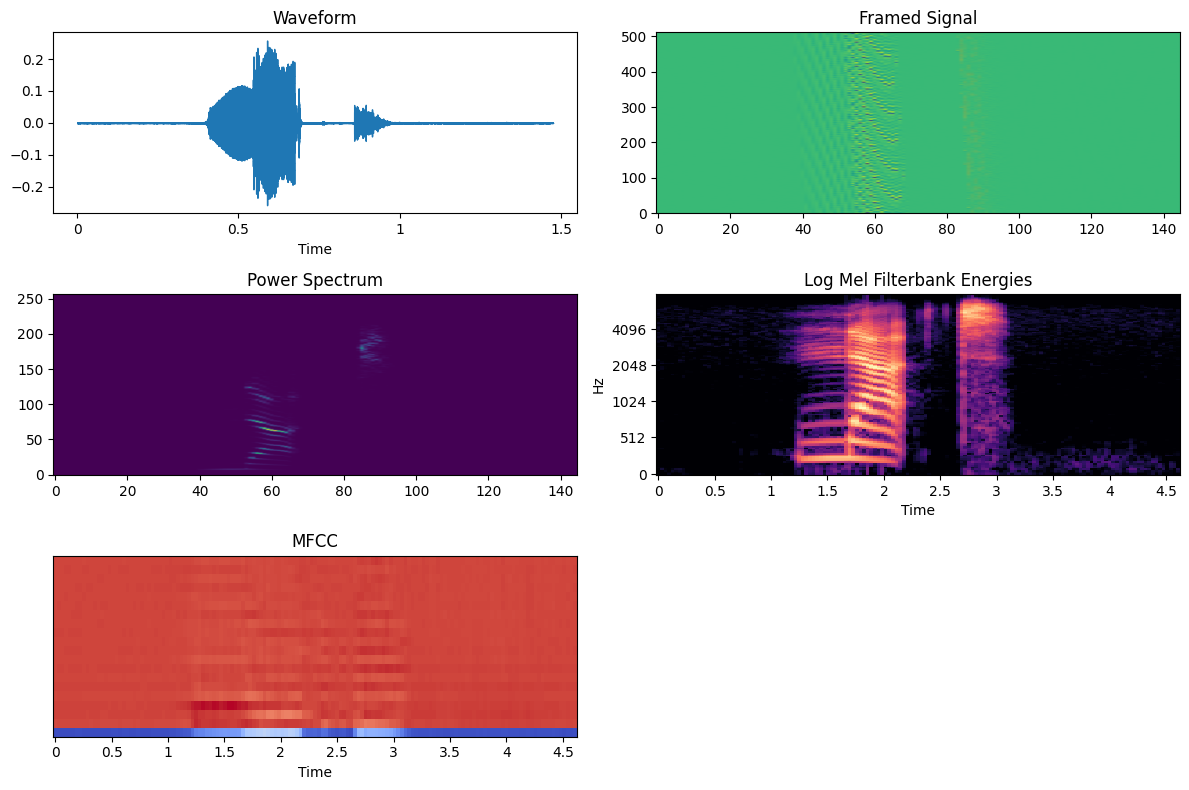

In [15]:
import librosa
import librosa.display
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

# 1. 오디오 로드
waveform, sample_rate = torchaudio.load(audio_path)
print(sample_rate)

# (A) Pre-emphasis (칼디는 옵션)
pre_emphasis = 0.97
waveform_preem = waveform[0].numpy()
waveform_preem = np.append(waveform_preem[0], waveform_preem[1:] - pre_emphasis * waveform_preem[:-1])

# (B) Framing + Windowing
n_fft = 512           # 25ms @ 16kHz
hop_length = 160      # 10ms @ 16kHz
window = np.hamming(n_fft)

# 프레임 나누기
frames = librosa.util.frame(waveform_preem, frame_length=n_fft, hop_length=hop_length).T
windowed_frames = frames * window

# (C) FFT → Power Spectrum
mag_frames = np.absolute(np.fft.rfft(windowed_frames, n_fft))
pow_frames = ((1.0 / n_fft) * (mag_frames ** 2))

# (D) Mel Filter Bank 적용
mel_filterbank = librosa.filters.mel(sr=sample_rate, n_fft=n_fft, n_mels=128, fmin=0, fmax=sample_rate/2)
mel_energies = np.dot(pow_frames, mel_filterbank.T)

# (E) 로그 변환
log_mel_energies = np.log(np.maximum(mel_energies, 1e-10))

# (F) DCT → MFCC
mfcc = librosa.feature.mfcc(S=log_mel_energies.T, n_mfcc=20)
mfccs = librosa.util.normalize(mfcc)  # -1~1로 정규화

# =========================
# 시각화
# =========================
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
librosa.display.waveshow(np.array(waveform[0]), sr=sample_rate)
plt.title("Waveform")

plt.subplot(3, 2, 2)
plt.imshow(frames.T, aspect='auto', origin='lower')
plt.title("Framed Signal")

plt.subplot(3, 2, 3)
plt.imshow(pow_frames.T, aspect='auto', origin='lower')
plt.title("Power Spectrum")

plt.subplot(3, 2, 4)
librosa.display.specshow(log_mel_energies.T, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title("Log Mel Filterbank Energies")

plt.subplot(3, 2, 5)
librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
plt.title("MFCC")

plt.tight_layout()
plt.show()

- mfcc 추출이 잘 되지 않고 있는 모습이다.
- 음성이 0.5~1 사이에 뭉쳐져 있고, 음성이 너무 짧다면 MFCC가 제대로 나오지 않을 수 있다.